# LASSO REGRESSION (SQRT Transformed)

In [29]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [30]:
df = pd.read_csv('clean_and_encoded_df.csv')

# Apply sqrt transformation to Annual_salary
df['Annual_salary'] = np.sqrt(df['Annual_salary'])

# Assuming you have a DataFrame called 'df'
baseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary"]

# Add Job_title columns to the baseline_cols list
Job_title = ['Developer, game or graphics', 'Blockchain', 'Developer, QA or test', 'Developer, back-end', 'Student', 
             'Project manager', 'Data or business analyst', 'Cloud infrastructure engineer', 'Engineer, data', 
             'Educator', 'Developer, desktop or enterprise applications', 'Developer, front-end', 'Designer', 
             'Security professional', 'Developer, embedded applications or devices', 'Product manager', 'Developer, mobile', 
             'Developer, full-stack', 'Scientist', 'Database administrator', 'Academic researcher', 'Senior Executive (C-Suite, VP, etc.)', 
             'Marketing or sales professional', 'System administrator', 'Data scientist or machine learning specialist', 
             'Engineer, site reliability', 'DevOps specialist', 'Engineering manager']

baseline_cols.extend(Job_title)

# Iterate through the columns and keep only those containing the specified keywords
columns_to_keep = [col for col in df.columns if any(keyword in col for keyword in baseline_cols)]

# Filter the DataFrame, keeping only the selected columns
baseline_df = df[columns_to_keep]


baseline_df.head()

,Education,Company_size,Age,Job_type_Full-time employed,Job_type_Independent contractor / Freelancer / Self-employed,Job_type_Other,Job_type_Part-time employed,Country_Andorra,Country_Angola,Country_Argentina,...,Marketing or sales professional,Product manager,Project manager,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",Student,System administrator,Work_experience,Annual_salary
0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,4.8,200.511845
1,3.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,6.4,229.715041
2,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,6.0,232.432786
3,2.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,7.8,268.780580
4,0.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,11.4,250.639183


In [31]:
df.Annual_salary.describe()

count    2805.000000
mean      265.435852
std        88.196888
min       100.254676
25%       201.308221
50%       257.138095
75%       321.312932
max       505.964426
Name: Annual_salary, dtype: float64

Baseline model:

In [32]:
base_X = baseline_df.drop('Annual_salary', axis=1)
y = baseline_df['Annual_salary']
print(base_X.shape)
print(y.shape)

(2805, 138)
(2805,)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(base_X, y, test_size=0.2, random_state=42)
y_train = y_train.reset_index(drop=True)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
'''from scipy.stats import loguniform

lasso = Lasso()
param_dist = {'alpha': loguniform(10**(-4), 10**3)}  # Adjust the range of alpha values if needed

random_search_lasso = RandomizedSearchCV(lasso, param_dist, scoring='r2', n_iter=100, cv=5, random_state=42)
random_search_lasso.fit(X_train_scaled, y_train)

best_alpha_random = random_search_lasso.best_params_['alpha']
best_score_random = random_search_lasso.best_score_
print(f"Best alpha (Randomized Search): {best_alpha_random}")
print(f"Best R2 score (Randomized Search): {best_score_random:.3f}")'''


'from scipy.stats import loguniform\n\nlasso = Lasso()\nparam_dist = {\'alpha\': loguniform(10**(-4), 10**3)}  # Adjust the range of alpha values if needed\n\nrandom_search_lasso = RandomizedSearchCV(lasso, param_dist, scoring=\'r2\', n_iter=100, cv=5, random_state=42)\nrandom_search_lasso.fit(X_train_scaled, y_train)\n\nbest_alpha_random = random_search_lasso.best_params_[\'alpha\']\nbest_score_random = random_search_lasso.best_score_\nprint(f"Best alpha (Randomized Search): {best_alpha_random}")\nprint(f"Best R2 score (Randomized Search): {best_score_random:.3f}")'

Hyperparameter tunning:

In [35]:
# With ADJ R2
k = 5
num_val_samples = len(X_train_scaled) // k
all_scores_r2 = []
all_scores_adjusted_r2 = []
all_scores_rmse = []
all_scores_mae = []


for i in range(k):
    print('processing fold #', i)
    val_data = X_train_scaled[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([X_train_scaled[:i * num_val_samples], X_train_scaled[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([y_train[:i * num_val_samples], y_train[(i + 1) * num_val_samples:]], axis=0)

    model = Lasso(alpha=0.397)
    model.fit(partial_train_data, partial_train_targets)

    val_preds = model.predict(val_data)
    # Reverse sqrt transformation
    val_preds_sqrd = val_preds**2 
    val_targets_sqrd = val_targets**2 

    r2_val = r2_score(val_targets_sqrd, val_preds_sqrd)
    n = val_data.shape[0]
    p = val_data.shape[1]
    adjusted_r2_val = 1 - (1 - r2_val) * (n - 1) / (n - p - 1)
    rmse_val = np.sqrt(mean_squared_error(val_targets_sqrd, val_preds_sqrd))
    mae_val = mean_absolute_error(val_targets_sqrd, val_preds_sqrd)

    all_scores_r2.append(r2_val)
    all_scores_adjusted_r2.append(adjusted_r2_val)
    all_scores_rmse.append(rmse_val)
    all_scores_mae.append(mae_val)


mean_r2 = np.mean(all_scores_r2)
std_r2 = np.std(all_scores_r2)
mean_adjusted_r2 = np.mean(all_scores_adjusted_r2)
std_adjusted_r2 = np.std(all_scores_adjusted_r2)
mean_rmse = np.mean(all_scores_rmse)
std_rmse = np.std(all_scores_rmse)
mean_mae = np.mean(all_scores_mae)
std_mae = np.std(all_scores_mae)

print(f"Average R2 score (Lasso): {mean_r2:.3f} (+/- {std_r2:.3f})")
print(f"Average adjusted R2 score (Lasso): {mean_adjusted_r2:.3f} (+/- {std_adjusted_r2:.3f})")
print(f"Average RMSE score (Lasso): {mean_rmse:.3f} (+/- {std_rmse:.3f})")
print(f"Average MAE score (Lasso): {mean_mae:.3f} (+/- {std_mae:.3f})")



processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
Average R2 score (Lasso): 0.606 (+/- 0.017)
Average adjusted R2 score (Lasso): 0.430 (+/- 0.024)
Average RMSE score (Lasso): 31743.922 (+/- 1271.391)
Average MAE score (Lasso): 23032.665 (+/- 1080.476)


In [36]:
lasso_results_dic = {}

lasso_results_dic['Lasso'] = {'R2': mean_r2,  'Adj R2': mean_adjusted_r2, 'RMSE': mean_rmse, 'MAE': mean_mae}
lasso_results = pd.DataFrame.from_dict(lasso_results_dic, orient='index')
lasso_results

,R2,Adj R2,RMSE,MAE
Lasso,0.6057,0.429605,31743.921923,23032.665418


In [37]:
lasso_results.to_csv('sqrt_lasso_results.csv', index=True)

In [38]:
# Combinar conjuntos de datos de entrenamiento y validación
X_train_val = np.concatenate((X_train_scaled, val_data), axis=0)
y_train_val = np.concatenate((y_train, val_targets), axis=0)

# Entrenar el modelo utilizando el conjunto de datos combinado
model.fit(X_train_val, y_train_val)

# Hacer predicciones en el conjunto de datos de prueba
y_pred = model.predict(X_test_scaled)

# Revertir la transformación logarítmica
y_pred_sqrd = y_pred**2 #np.exp(y_pred)
y_test_sqrd = y_test**2 #np.exp(y_test)

# Calcular métricas de rendimiento en el conjunto de datos de prueba
r2_test = r2_score(y_test_sqrd, y_pred_sqrd)
rmse_test = np.sqrt(mean_squared_error(y_test_sqrd, y_pred_sqrd))
mae_test = mean_absolute_error(y_test_sqrd, y_pred_sqrd)
n_test = len(X_test_scaled)
p_test = X_train_val.shape[1]
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)

print(f"Rendimiento R2 en el conjunto de prueba (MLR): {r2_test:.3f}")
print(f"Rendimiento adjusted R2 en el conjunto de prueba (MLR): {adjusted_r2_test:.3f}")
print(f"Rendimiento RMSE en el conjunto de prueba (MLR): {rmse_test:.3f}")
print(f"Rendimiento MAE en el conjunto de prueba (MLR): {mae_test:.3f}")



Rendimiento R2 en el conjunto de prueba (MLR): 0.612
Rendimiento adjusted R2 en el conjunto de prueba (MLR): 0.484
Rendimiento RMSE en el conjunto de prueba (MLR): 31604.800
Rendimiento MAE en el conjunto de prueba (MLR): 22970.036


In [39]:
test_results_dic = {}
test_results_dic['Lasso'] = {'R2': r2_test,  'Adj R2': adjusted_r2_test, 'RMSE': rmse_test, 'MAE': mae_test}
test_results = pd.DataFrame.from_dict(test_results_dic, orient='index')
test_results

,R2,Adj R2,RMSE,MAE
Lasso,0.611522,0.484484,31604.800333,22970.035896


In [40]:
test_results.to_csv('sqrt_test_lasso_results.csv', index=True)

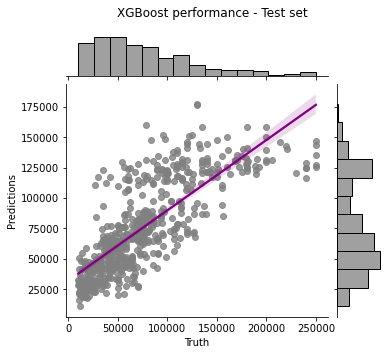

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una cuadrícula de gráficos conjunta y configurar los ejes para los histogramas
g = sns.JointGrid(x=y_test_sqrd, y=y_pred_sqrd, height=5)

# Crear un gráfico de dispersión y ajustar una línea de regresión lineal a los datos
g.plot_joint(sns.regplot, scatter_kws={'color': 'grey'}, line_kws={'color': 'purple'})

# Agregar histogramas en la parte superior y en el lado derecho del gráfico
g.plot_marginals(sns.histplot, kde=False, color='grey')

# Ajustar el espacio entre los subgráficos y mover el título hacia arriba
g.fig.subplots_adjust(top=0.9)

# Agregar título
g.fig.suptitle("XGBoost performance - Test set")

# Etiquetar los ejes
g.ax_joint.set_xlabel("Truth")
g.ax_joint.set_ylabel("Predictions")

plt.show()



In [42]:
# Fit the Lasso model using the best alpha value and the entire training set
best_alpha_lasso = 0.397
lasso_model = Lasso(alpha=best_alpha_lasso)
lasso_model.fit(X_train_scaled, y_train)

# Get the feature coefficients
coefficients = lasso_model.coef_

# Get the feature names from the DataFrame
feature_names = X_train.columns

# Print the coefficients and the corresponding feature names
for coef, feature in zip(coefficients, feature_names):
    print(f"{feature}: {coef:.3f}")

# Get the features with non-zero coefficients
selected_features = [feature for coef, feature in zip(coefficients, feature_names) if coef != 0]
print(f"\nSelected features by Lasso: {selected_features}")

Education: 4.890
Company_size: 4.372
Age: 2.891
Job_type_Full-time employed: 0.000
Job_type_Independent contractor / Freelancer / Self-employed: 1.498
Job_type_Other: -0.000
Job_type_Part-time employed: -4.188
Country_Andorra: -0.526
Country_Angola: 0.000
Country_Argentina: -5.494
Country_Armenia: -0.000
Country_Australia: 12.197
Country_Austria: 1.613
Country_Azerbaijan: 0.000
Country_Bangladesh: -1.486
Country_Barbados: -0.530
Country_Belarus: 0.336
Country_Belgium: 0.000
Country_Bosnia-Herz.: -1.504
Country_Botswana: -1.707
Country_Brazil: -8.242
Country_Bulgaria: -1.497
Country_Canada: 14.089
Country_Chile: -1.571
Country_China: 2.627
Country_Colombia: -4.897
Country_Costa Rica: 0.104
Country_Croatia: -2.096
Country_Cyprus: -0.347
Country_Czech Republic: -0.424
Country_CÃ´te d'Ivoire: -0.511
Country_Denmark: 5.718
Country_Dominican Republic: -0.864
Country_Ecuador: -1.340
Country_Egypt: -3.243
Country_El Salvador: -0.656
Country_Estonia: -1.178
Country_Finland: 2.621
Country_France

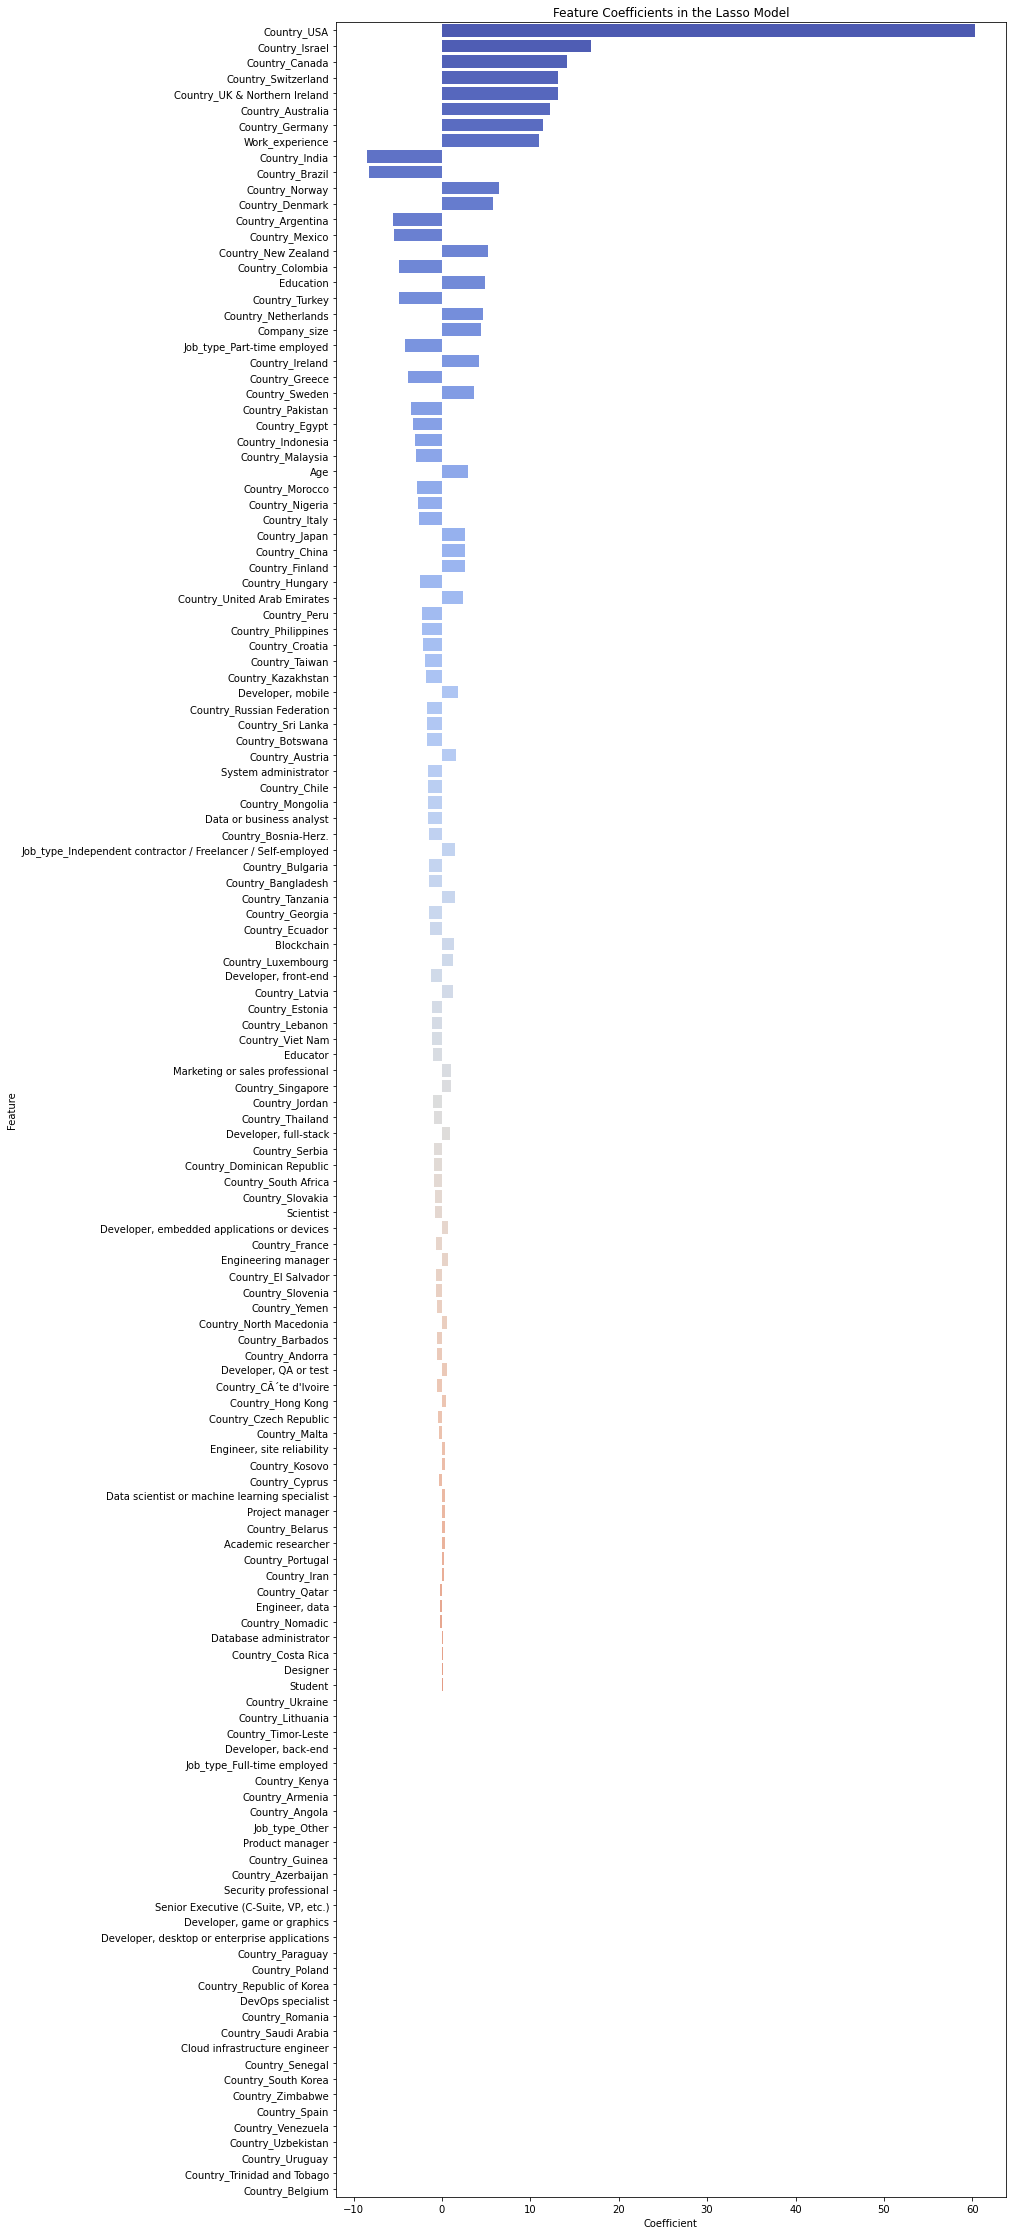

In [43]:
# Create a DataFrame with the feature names and their corresponding coefficients
coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefficients})

# Sort the DataFrame by the absolute value of the coefficients in descending order
coef_df = coef_df.reindex(coef_df.coef.abs().sort_values(ascending=False).index)

# Create a bar plot of the feature coefficients
plt.figure(figsize=(12, 40))
sns.barplot(data=coef_df, x='coef', y='feature', palette='coolwarm')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Coefficients in the Lasso Model')
plt.show()